In [1]:
import scipy
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# params
batch_size= 128

In [3]:
# import data from moving mnist dataset
data = np.load('data/bouncing_mnist_test.npy')
data = data / 255
train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)


In [2]:
class VRNN(nn.Module):

    def __init__(self, img_size=64, hidden_size=256, latent_size=16, RNN_dim=256, CNN_channels=32):

        super(VRNN, self).__init__()

        self.feature_size = img_size*img_size # (img_size-8)*(img_size-8)*CNN_channels
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.rnn_dim = RNN_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.feature_size + RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.enc_mean = nn.Linear(hidden_size, latent_size)
        self.enc_logvar = nn.Linear(hidden_size, latent_size)

        self.prior_encoder = nn.Sequential(
            nn.Linear(RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.prior_mean = nn.Linear(hidden_size, latent_size)
        self.prior_logvar = nn.Linear(hidden_size, latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size + RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.dec_mean = nn.Linear(hidden_size, self.feature_size)
        # self.dec_logvar = nn.Linear(hidden_size, self.feature_size)

        self.rnn = nn.RNN(self.feature_size + latent_size, RNN_dim) # could try with a GRU or an LSTM

    def reparametrization(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + std * eps
    

    def forward(self,x):

        seq_len, batch_size,_ = x.shape

        # create variable holder
        self.z_mean = torch.zeros(seq_len, batch_size, self.latent_size)
        self.z_logvar = torch.zeros(seq_len, batch_size, self.latent_size)
        self.z = torch.zeros(seq_len, batch_size, self.latent_size)

        h = torch.zeros((seq_len, batch_size, self.rnn_dim))
        z_t = torch.zeros((batch_size, self.latent_size))
        h_t = torch.zeros((batch_size, self.rnn_dim)) # the initial hidden state coudl be different from 0 ... (random ?)

        y = torch.zeros((seq_len, batch_size, self.input_size)) # observation reconstruction
        
        for t in range(seq_len):

            # encode
            x_t = x[t,:,:]
            encoder_input = torch.cat((x_t,h_t),dim=1)
            encoder_output = self.encoder(encoder_input)
            mean_zt, logvar_zt = self.enc_mean(encoder_output), self.enc_logvar(encoder_output)

            # sample the latent variable
            z_t = self.reparametrization(mean_zt, logvar_zt)

            # decode
            decoder_input = torch.cat((z_t,h_t),dim=1)
            decoder_output = self.decoder(decoder_input)
            mean_xt, logvar_xt = self.dec_mean(decoder_output), self.dec_logvar(decoder_output)
            y_t = mean_xt # for now we will not sample from the decoder

            # update the hidden state
            rnn_input = torch.cat((x_t,z_t),dim=1)
            h_t = self.rnn(rnn_input.unsqueeze(0),h_t.unsqueeze(0))[1].squeeze(0) # looooool

            # save variable
            y[t,:,:] = y_t
            self.z_mean[t,:,:] = mean_zt
            self.z_logvar[t,:,:] = logvar_zt
            self.z[t,:,:] = z_t
            h[t,:,:] = h_t

        # generation of the latent variable z prior (for the KL divergence)
        prior_encoder_output = self.prior_encoder(h)
        self.z_prior_mean = self.prior_mean(prior_encoder_output)
        self.z_prior_logvar = self.prior_logvar(prior_encoder_output)

        return y,  self.z_mean, self.z_logvar, self.z_prior_mean, self.z_prior_logvar, self.z

In [3]:
mseLoss = torch.nn.MSELoss()

def loss_function(x_reconstructed, x, mean, logvar, mean_prior=None, logvar_prior=None):
    if mean_prior is None :
        mean_prior = torch.zeros_like(mean)
    if logvar_prior is None :
        logvar_prior = torch.zeros_like(logvar)
    # reconstruction loss
    recon_loss = mseLoss(x_reconstructed,x)
    # KL divergence
    kl_loss = -0.5 * torch.sum(logvar - logvar_prior - torch.div((logvar.exp() + (mean - mean_prior).pow(2)), logvar_prior.exp()+1e-10))
    return recon_loss + kl_loss

'\nx = torch.ones((2,513,4096)) #seq_len * batch_size * input_size\ny, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(x)\nprint(loss_function(y,x,mean,logvar,mean_prior,logvar_prior)/6)\n'

In [4]:
vrnn = VRNN(img_size=64, hidden_size= 256, latent_size= 32, RNN_dim=256)
opt = torch.optim.Adam(vrnn.parameters())

In [5]:
nb_epochs = 1

def train(nb_epochs=1,batch_size=100):
    for epoch in range(nb_epochs):
        pbar = tqdm(train_loader)
        pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
        for x in pbar:
            x = torch.reshape(x,(batch_size,20,64,64)).float()
            opt.zero_grad()
            y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(x)
            loss = loss_function(y,x,mean,logvar,mean_prior,logvar_prior)
            loss.backward()
            opt.step()
            pbar.set_description("epoch "+str(epoch+1)+"/"+str(nb_epochs)+"/ loss= "+str(loss.detach().numpy()) )


train(nb_epochs=1,batch_size=100)

epoch 1/1/ loss= 260499.38: 100%|██████████| 100/100 [14:13<00:00,  8.54s/it]


(20, 64, 64)

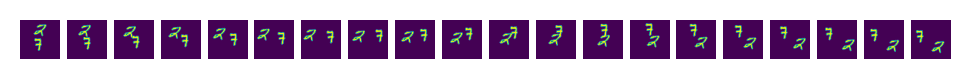

In [7]:
# test the reconstruction
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
sample = data[0]


def plot_video(video):
    fig,ax = plt.subplots(1,20)
    for i in range(20):
        ax[i].imshow(video[i,:,:])
        ax[i].axis('off')

plot_video(sample)
sample.shape

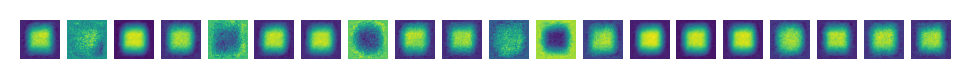

In [8]:
sample_tensor = torch.reshape(torch.tensor(sample).float(),(1,20,-1)).float()
y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(sample_tensor)
reconstructed_sample = y.detach().numpy().reshape((20,64,64))

plot_video(reconstructed_sample)